In [1]:
##Testing notebook for heat eq solver with immersed boundary method
##likely need a gpu with at least 24 gb memory depending on your mesh
import numpy as np
import torch
import jax.numpy as jnp
from jax import jit, grad, vmap
from scipy.spatial import KDTree
from jax.experimental import sparse
import jax

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
#jit had a few bugs that I couldn't fix, performance is decent without it
jax.config.update("jax_disable_jit", True)
#os.environ['JAX_PLATFORM_NAME'] = 'cpu'

In [2]:
X_data = np.load("/home/iyer.ris/Pipe_X.npy")
Y_data = np.load("/home/iyer.ris/Pipe_Y.npy")
velocity_data=np.load("/home/iyer.ris/pipe/Pipe_Q.npy")
randPipeX = X_data[45]
randPipeY = Y_data[45]
randQ=velocity_data[45]
print(randQ.shape)
#print(randPipeX[20,0],randPipeY[20,0],randQ[2,-1,:])


(3, 129, 129)


In [10]:
class Heat_eq_generation():
    def __init__(self, x_channel, y_channel, velocity_data, domain_size, grid_res):
        self.x_channel = x_channel
        self.y_channel = y_channel
        coords_list = []
        for col in np.arange(x_channel.shape[1]):
            coords_list = coords_list + list(zip(x_channel[col, :], y_channel[col, :]))
        coords = jnp.array(coords_list)
        self.tree = KDTree(coords)
        Lx, Ly = domain_size
        Nx, Ny = grid_res
        nx, ny= grid_res
        x = jnp.linspace(0, Lx, Nx)
        y = jnp.linspace(-Ly, Ly, Ny)
        self.dx = Lx / Nx
        self.dy = 2 * Ly / Ny
        self.xgrid, self.ygrid = jnp.meshgrid(x, y)
        self.u = self.interpolate(velocity_data, self.xgrid, self.ygrid)
        
        self.mask = self.map_channel_geometry(self.xgrid, self.ygrid)
        alpha_aluminum = 64 * 10**-6
        alpha_water = 0.143 * 10**-6
        alpha_field = jnp.where(self.mask == True, alpha_water, alpha_aluminum)
        #had bugs with vmap and jit in these sections
        self.assemble_coefficients_matrix_vmapped = self.assemble_coefficients_matrix
        self.apply_boundary_conditions_vmapped = self.apply_boundary_conditions
        self.T = self.solve_steady_state(alpha_field, self.u[:,:,0], self.u[:,:,1], self.mask, nx, ny, self.dx, self.dy)


    def is_inside_channel(self, x, y):
        inside = False
        nearest_dist, nearest_idx = self.tree.query((x, y), 1)
        nearest_point = self.tree.data[nearest_idx]
        nearest_x, nearest_y = nearest_point

        # Find the indices where the nearest x-coordinate occurs in the meshgrid
        x_indices = np.where(self.x_channel == nearest_x)

        if len(x_indices[0]) > 0:
            # Check if the y-coordinate is within the range of y-coordinates at the nearest x-coordinate
            row_index, col_index = x_indices[0][0], x_indices[1][0]
            if self.y_channel[row_index, col_index] <= y <= self.y_channel[row_index, -1]:
                inside = True

        return inside

    def map_channel_geometry(self, X, Y):
        # Create a mask array to represent the channel geometry
        mask = np.zeros_like(X, dtype=bool)

        # Iterate over the grid points and determine if each point lies inside the channel
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                mask[i, j] = self.is_inside_channel(X[i, j], Y[i, j])

        return mask

    def interpolate(self, velocity_data, xgrid, ygrid):
        grid_points = jnp.stack((xgrid, ygrid), axis=-1)

        # Perform KDTree queries for all grid points
        distances, indices = self.tree.query(grid_points, k=4)

        # Parallelize the interpolation using vmap and jit
        interpolate_vectorized = jit(vmap(vmap(lambda point, dist, idx: self.interpolate_point(point, dist, idx, velocity_data), in_axes=(0, 0, 0)), in_axes=(0, 0, 0)))
        u = interpolate_vectorized(grid_points, distances, indices)

        return u

    @staticmethod
    @jit
    def interpolate_point(point, distances, indices, velocity_data):
        weights = 1.0 / distances
        weights /= jnp.sum(weights)
    
        velocity_sum = jnp.zeros(2)
        for k in range(4):
            idx = indices[k]
            velocity_sum = velocity_sum.at[0].add(weights[k] * jnp.take(velocity_data[0], idx))
            velocity_sum = velocity_sum.at[1].add(weights[k] * jnp.take(velocity_data[1], idx))
    
        return velocity_sum

    
    
    
    @staticmethod
    def assemble_coefficients_matrix(alpha_field, velocity_field_x, velocity_field_y, nx, ny, dx, dy):
        A = jnp.zeros((nx * ny, nx * ny))
        
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                #up and down is i, left right is j
                index = j * nx + i
                
                # Diffusion terms
                A = A.at[index, index].add(-2 * alpha_field[i, j] / (dx**2) - 2 * alpha_field[i, j] / (dy**2))
                A = A.at[index, index - 1].add(alpha_field[i-1, j] / (dy**2))
                A = A.at[index, index + 1].add(alpha_field[i+1, j] / (dy**2))
                A = A.at[index, index - ny].add(alpha_field[i, j-1] / (dx**2))
                A = A.at[index, index +ny].add(alpha_field[i, j+1] / (dx**2))

                #eqn: -udotgradT+alpha*graddotgradT=0
                # Advection terms
                A = jax.lax.cond(
                    velocity_field_x[i, j] > 0,
                    lambda: A.at[index, index].add(-velocity_field_x[i, j] / dx).at[index, index - ny].add(velocity_field_x[i, j] / dx),
                    lambda: A.at[index, index].add(velocity_field_x[i, j] / dx).at[index, index + ny].add(-velocity_field_x[i, j] / dx)
                )
                
                A = jax.lax.cond(
                    velocity_field_y[i, j] > 0,
                    lambda: A.at[index, index].add(-velocity_field_y[i, j] / dy).at[index, index - 1].add(velocity_field_y[i, j] / dy),
                    lambda: A.at[index, index].add(velocity_field_y[i, j] / dy).at[index, index + 1].add(-velocity_field_y[i, j] / dy)
                )
        
        return A
        
    @staticmethod
    def apply_boundary_conditions(A, b, mask, nx, ny, dx, dy):
        for i in range(nx):
            for j in range(ny):
                #up and down is i, left right is j
                index = j * nx + i
                
                if j == 0:
                    if mask[i, j] == True:
                        # Dirichlet BCs if in fluid inlet
                        A = A.at[index, index].set(1)
                        b = b.at[index].set(1000)
                    else:
                        A = A.at[index, index].set(20 / 237 + 1 / dx)
                        A = A.at[index, index + ny].set(20 / 237 - 1 / dx)
                        b = b.at[index].set(400 / 237)  # h/k * air temp 20c room temp
                
                elif j == nx - 1:
                    if mask[i, j] == True:
                        # Fully thermally developed
                        A = A.at[index, index].set(1 / dx)
                        A = A.at[index, index - ny].set(-1 / dx)
                        b = b.at[index].set(0)
                    else:
                        A = A.at[index, index].set(20 / 237 + 1 / dx)
                        A = A.at[index, index - ny].set(20 / 237 - 1 / dx)
                        b = b.at[index].set(400 / 237)  # h/k * air temp 20c room temp
                
                elif i == 0:
                    # Bottom
                    A = A.at[index, index].set(20 / 237 + 1 / dy)
                    A = A.at[index, index + 1].set(20 / 237 - 1 / dy)
                    b = b.at[index].set(400 / 237)
                
                elif i == nx - 1:
                    # Top
                    A = A.at[index, index].set(20 / 237 - 1 / dy)
                    A = A.at[index, index - 1].set(20 / 237 + 1 / dy)
                    b = b.at[index].set(400 / 237)
        
        return A, b
    
    def solve_steady_state(self, alpha_field, velocity_field_x, velocity_field_y, mask, nx, ny, dx, dy):
        A = self.assemble_coefficients_matrix_vmapped(alpha_field, velocity_field_x, velocity_field_y, nx, ny, dx, dy)
        b = jnp.zeros(nx * ny)
        A, b = self.apply_boundary_conditions_vmapped(A, b, mask, nx, ny, dx, dy)
        T = jax.numpy.linalg.solve(A, b).reshape((ny, nx)).T
        return T



domain_size = (10, 2.0)  # Domain size
grid_res = (100, 100)  # Grid resolution
heatobj = Heat_eq_generation(randPipeX, randPipeY, randQ, domain_size, grid_res)

[-2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.]


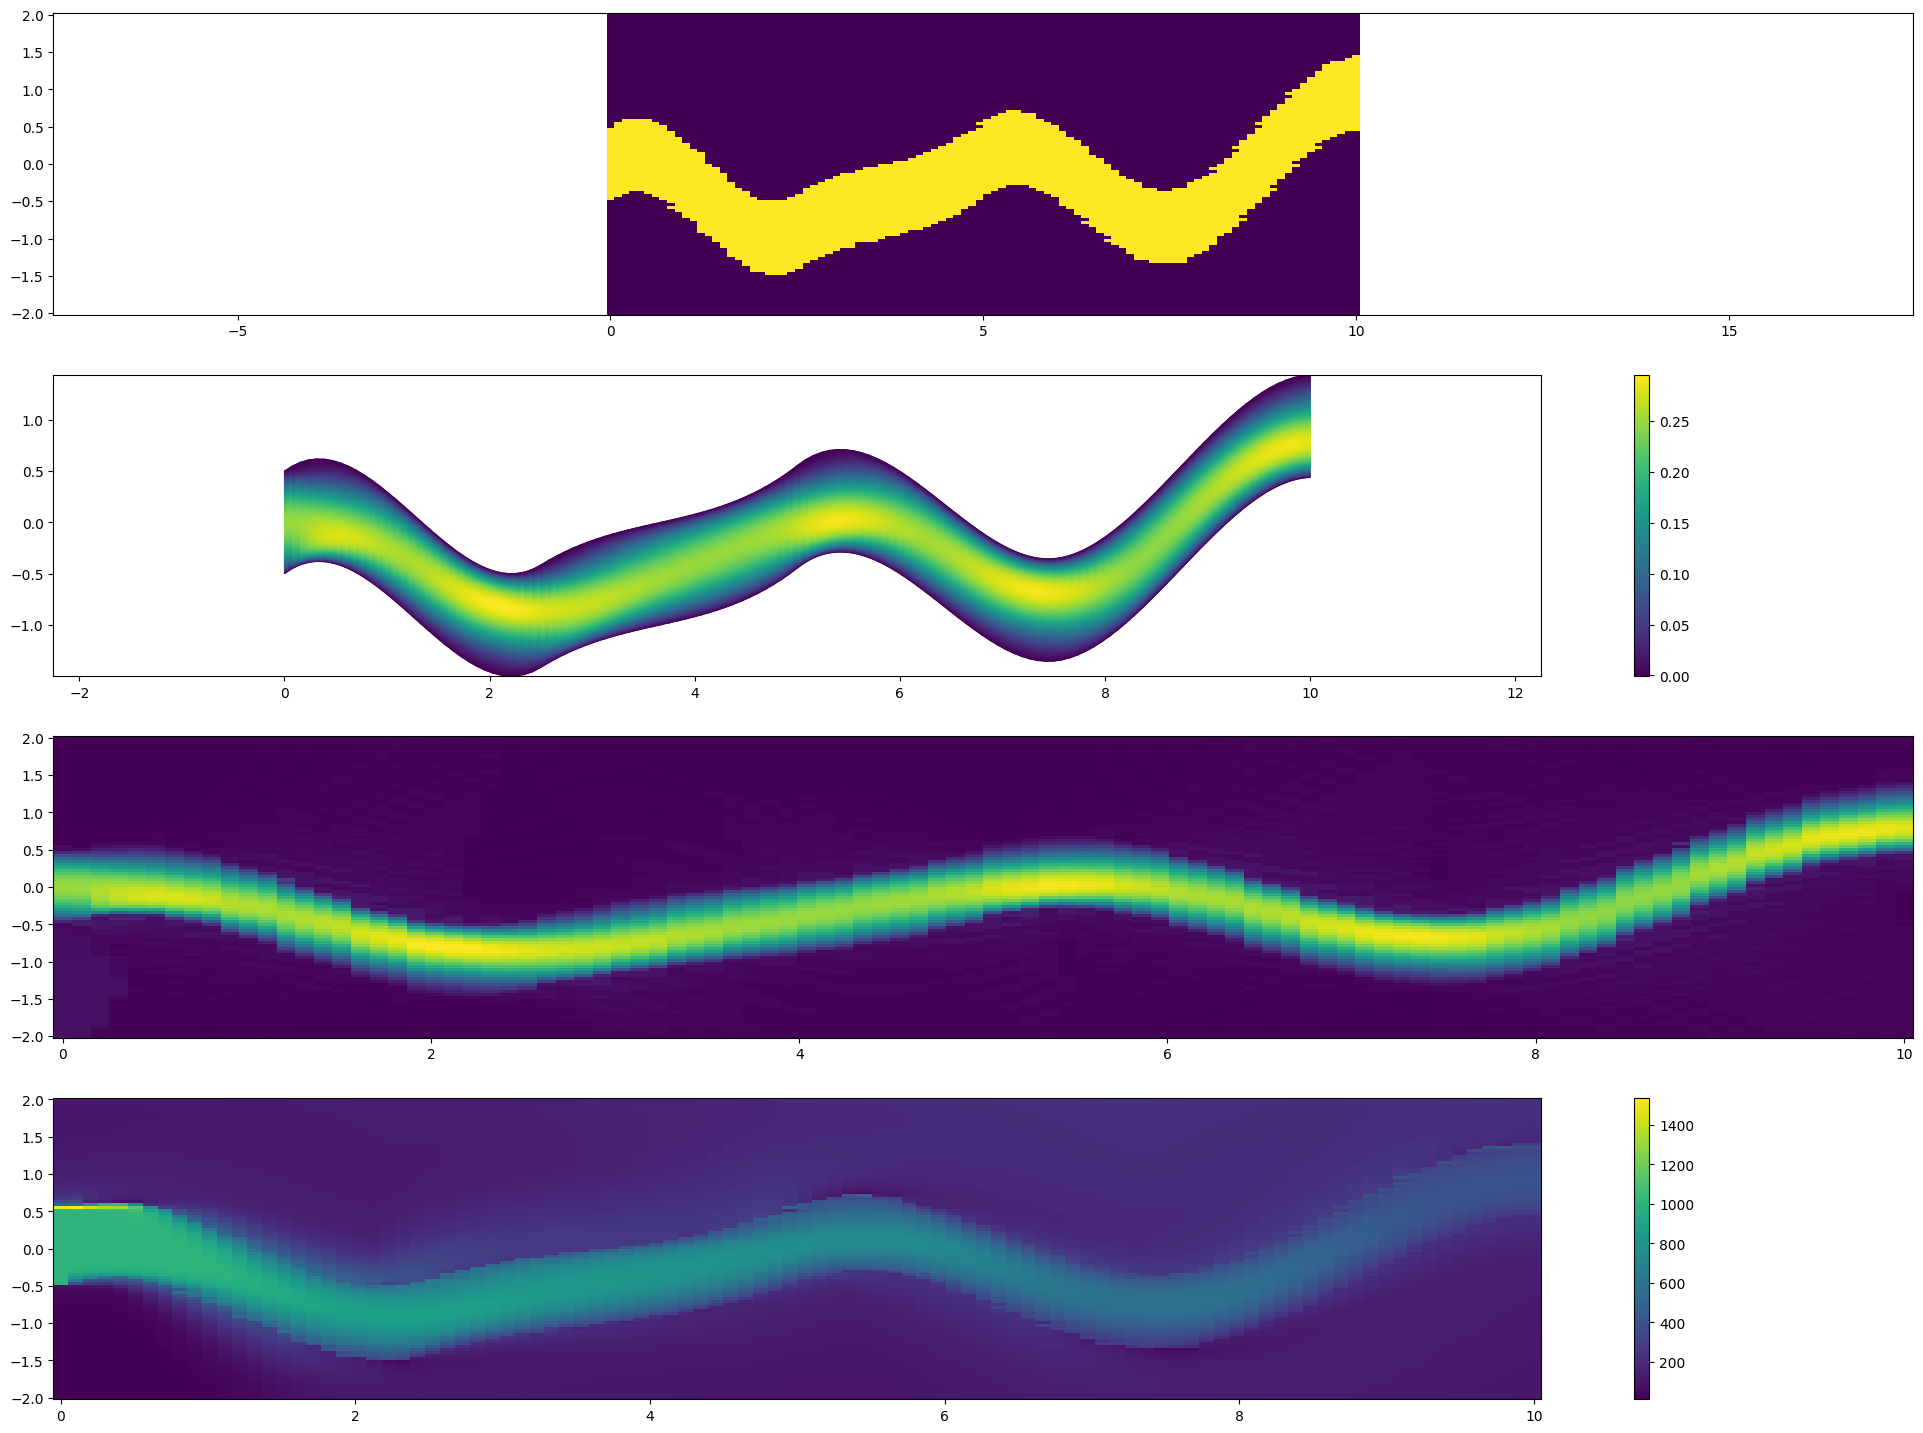

In [11]:
import matplotlib.pyplot as plt
print(heatobj.ygrid[0,:])


fig,ax=plt.subplots(4,1,figsize=(24,18))
# Plot the original meshgrid
im0=ax[0].pcolormesh(heatobj.xgrid,heatobj.ygrid,heatobj.mask)
im1 = ax[1].pcolormesh(randPipeX,randPipeY, randQ[0,:,:], shading='gouraud')
im2= ax[2].pcolormesh(heatobj.xgrid,heatobj.ygrid,heatobj.u[:,:,0])
#ax1.plot(randPipeX.T, randPipeY.T, 'b-', linewidth=0.5)
im3=ax[3].pcolormesh(heatobj.xgrid,heatobj.ygrid,heatobj.T)
ax[0].axis('equal')

fig.colorbar(im1, ax = ax[1])
ax[1].axis('equal')

fig.colorbar(im3)
# Display the plot
plt.show()
